In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
new_transactions = pd.read_csv('~/media/s3/sandbox/Kaggle Crowd/Elo Merchant Category/elo_new_merchant_transactions.csv',
                               parse_dates=['purchase_date'])

historical_transactions = pd.read_csv('~/media/s3/sandbox/Kaggle Crowd/Elo Merchant Category/elo_historical_transactions.csv',
                                      parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [4]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________
train = read_data('~/media/s3/sandbox/Kaggle Crowd/Elo Merchant Category/elo_train.csv')
test = read_data('~/media/s3/sandbox/Kaggle Crowd/Elo Merchant Category/elo_test.csv')

target = train['target']
del train['target']

In [5]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [6]:
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,13
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,13
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,14
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,14
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,14


In [7]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


In [8]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [9]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [10]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,0.828571,0.171429,11,8,2,3,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,13.257143
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,1.000000,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,13.000000
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,0.250000,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,13.500000
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,0.185185,0.000000,17,14,4,8,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,17.407407
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.428571,0.571429,4,4,1,1,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,13.285714


In [11]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,0.842105,0.157895,28,18,3,4,13,-62.443077,-0.547746,1.206539,-0.728876,0.237426,147,1.289474,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,13.482456
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,0.708333,0.266667,65,29,6,18,17,-70.657272,-0.588811,0.768095,-0.734887,0.192614,195,1.625000,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,13.258333
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,0.000000,0.000000,28,19,2,3,12,-31.696098,-0.511227,1.493545,-0.740491,0.484575,0,0.000000,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,13.387097
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,0.000000,0.000000,114,45,4,9,22,-24.960674,-0.132067,4.554145,-0.737892,0.867916,0,0.000000,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,17.238095
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,0.729927,0.240876,71,34,7,9,20,-67.896553,-0.495595,2.764788,-0.737892,0.523760,245,1.788321,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,13.343066


In [12]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,1.000000,0.000000,2,2,2,2,2,-1.328125,-0.664062,-0.656738,-0.671875,0.010704,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,13.500000
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,0.807692,0.153846,25,15,4,8,9,-14.851562,-0.571289,-0.078308,-0.740723,0.173462,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,13.153846
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,0.000000,0.000000,1,2,1,1,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011742,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,13.000000
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,0.000000,0.000000,31,21,5,7,14,-0.229004,-0.007385,3.130859,-0.737793,0.947266,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,17.000000
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,0.545455,0.363636,11,9,2,2,6,-6.589844,-0.599121,-0.107666,-0.732422,0.182861,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,13.545455


In [13]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.702649,0.041293,-0.126683,0.446167,0.197339,0.120199,8.769231,3.539158,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,0.002699,-0.160977,0.485869,0.151393,0.093832,20.000000,11.696153,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,0.011212,0.161333,0.748701,0.496308,0.415117,4.769231,4.342692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496067,4.018810,-0.005687,0.271221,-0.646277,0.166230,2.190924,1.290775,0.880276,0.259048,18.900000,12.160501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316092,4.800612,-0.489227,0.141015,-0.728405,0.009876,1.151797,1.062785,0.472149,0.315407,22.833333,7.167054,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557395,2.089708,-0.685118,0.071894,-0.728885,0.016051,-0.425292,0.813979,0.108521,0.208719,4.076923,4.290717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,0.030670,-0.546063,0.092512,0.076295,0.051724,6.090909,3.505839,10.727273,8.427229,1.965729,1.287108,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909524,-0.740077,0.002424,-0.742206,0.003025,-0.737762,0.002652,0.003165,0.001086,2.666667,1.224745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,0.020383,-0.210304,1.127668,0.213951,0.442601,3.500000,1.772811,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843051,3.021165,-0.638037,0.044976,-0.721448,0.026047,-0.387276,0.222295,0.107390,0.060790,9.166667,4.665476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [15]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [16]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [40]:
test.to_csv('test.csv')
train['target'] = target
train.to_csv('train.csv')
del train['target']

In [18]:
# ### Remove highly correlated variables ###

# # Create correlation matrix
# corr_matrix = train.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find features with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# # Drop features 
# train_filtered = train
# train_filtered = train_filtered.drop(to_drop, axis=1)
# test_filtered = test
# test_filtered = test_filtered.drop(to_drop, axis=1)

In [19]:
### Create vector identifying outliers ###
outlier = np.zeros(len(target))
outlier[target == min(target)] = 1

In [20]:
# unimportant_features = [
#     'auth_category_2_1.0_mean',
#     'auth_category_2_2.0_mean',
#     'auth_category_2_3.0_mean',
#     'auth_category_2_5.0_mean',
#     'hist_category_2_3.0_mean',
#     'hist_category_2_4.0_mean',
#     'hist_category_2_5.0_mean',
#     'hist_category_3_A_mean',
#     'hist_installments_min',
#     'hist_installments_std',
#     'hist_month_lag_std',
#     'hist_purchase_amount_max',
#     'hist_purchase_month_max',
#     'hist_purchase_month_min',
#     'hist_purchase_month_std',
#     'installments_min_mean',
#     'new_category_2_1.0_mean',
#     'new_category_2_2.0_mean',
#     'new_category_2_3.0_mean',
#     'new_category_2_5.0_mean',
#     'new_city_id_nunique',
#     'new_installments_std',
#     'new_state_id_nunique',
#     'purchase_amount_mean_mean'
# ]
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_2', 'feature_3']

In [21]:
### Run Boruta algorithm to filter further ###


In [22]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

## Functions for finding optimal cutoff

In [23]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [24]:
def calculate_cutoff(target, pred_targ, pred_prob):
    val_to_check = np.arange(0,max(pred_prob)+.001,0.0001)
    rmse_vals = np.zeros(len(val_to_check))
    new_score = np.zeros(len(target))

    for i in range(0,len(val_to_check)):
        new_score = np.array(list(pred_targ))
        new_score[pred_prob > val_to_check[i]] = min(target)
        rmse_vals[i] = (rmse(new_score,target))
    
    return val_to_check[np.argmin(rmse_vals)]

In [41]:
train_imputed = train.copy()
train_imputed = train_imputed.fillna(train_imputed.mean())

test_imputed = test.copy()
test_imputed = test_imputed.fillna(test_imputed.mean())

In [42]:
train_no_outliers = train_imputed.copy()
train_no_outliers = train_no_outliers[target.values > min(target)]
target = target[target.values > min(target)]

ValueError: Item wrong length 199710 instead of 201917.

In [ ]:
print(train_no_outliers.size)
print(train_imputed.size)

In [37]:
from sklearn.linear_model import LogisticRegression

folds = KFold(n_splits=5, shuffle=True, random_state=15)
cv_prob = np.zeros(len(train))
oof = np.zeros(len(train))
oof_classified = np.zeros(len(train))
predictions = np.zeros(len(test))
predictions_log = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()
opt_cutoff = []


### DO OUTLIER CLASSIFICATION WITHIN EACH FOLD OF THE CROSS VALIDATION AND GET THE OPTIMAL THRESHOLD ###
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_no_outliers.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_no_outliers.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train_no_outliers.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train_no_outliers.iloc[val_idx][features], num_iteration=clf.best_iteration)
    oof_classified[val_idx] = oof[val_idx]
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    # Fit Logistic regression on training fold
    
    #clf_log = LogisticRegression(random_state=0, solver='lbfgs',
    #                      multi_class='multinomial').fit(train_imputed.loc[trn_idx, features], outlier[trn_idx])
    
    clf_rf = RandomForestClassifier(n_estimators=500, max_depth=2,
                               random_state=0).fit(train_imputed.loc[trn_idx, features], outlier[trn_idx])
    
    cv_pred = np.zeros(len(val_idx))
    cv_pred = clf_rf.predict_proba(train_imputed.loc[val_idx, features])
    cv_prob[val_idx] = cv_pred[:,1]
    cutoff_in_fold = calculate_cutoff(target[val_idx], oof[val_idx], cv_pred[:,1])
    opt_cutoff.append(cutoff_in_fold)
    oof_classified[val_idx][cv_prob[val_idx] > cutoff_in_fold] = min(target)
    
#     predictions_log += clf_rf.predict_proba(test_imputed[features])[:,1] / folds.n_splits 
    
#predictions[predictions_log > mean(opt_cutoff)] = min(target)    
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

oof[cv_prob > mean(opt_cutoff)] = min(target)
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))


ValueError: Found input variables with inconsistent numbers of samples: [201917, 199710]

In [27]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof_classified, target)**0.5))
print(opt_cutoff)

CV score: 3.65516 
[0.0477, 0.0494, 0.0487, 0.049, 0.0489]


In [39]:
min(oof_classified)

-17.561392171728627

In [35]:
oof_classified[val_idx][cv_prob[val_idx] > cutoff_in_fold]

array([-33.21928095])

### Fit model using all training data

In [62]:
trn_data = lgb.Dataset(train[features],
                           label=target,
                           categorical_feature=categorical_feats
                          )
val_data = lgb.Dataset(train[features],
                           label=target,
                           categorical_feature=categorical_feats
                          )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [trn_data, val_data],
                verbose_eval=100,
                early_stopping_rounds = 200)
    

    
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = features
fold_importance_df["importance"] = clf.feature_importance()
fold_importance_df["fold"] = fold_ + 1
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
predictions = clf.predict(test[features], num_iteration=clf.best_iteration)
    
# Fit Logistic regression on training fold
    
#clf_log = LogisticRegression(random_state=0, solver='lbfgs',
#                      multi_class='multinomial').fit(train_imputed.loc[trn_idx, features], outlier[trn_idx])
    
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=2,
                               random_state=0).fit(train_imputed, outlier)
    

pred_probs = clf_rf.predict_proba(train_imputed[features])[:,1]
    
    



fold n°4


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.7215	valid_1's rmse: 3.7215
[200]	training's rmse: 3.65388	valid_1's rmse: 3.65388
[300]	training's rmse: 3.61135	valid_1's rmse: 3.61135
[400]	training's rmse: 3.58136	valid_1's rmse: 3.58136
[500]	training's rmse: 3.55842	valid_1's rmse: 3.55842
[600]	training's rmse: 3.54026	valid_1's rmse: 3.54026
[700]	training's rmse: 3.52487	valid_1's rmse: 3.52487
[800]	training's rmse: 3.51098	valid_1's rmse: 3.51098
[900]	training's rmse: 3.4989	valid_1's rmse: 3.4989
[1000]	training's rmse: 3.48731	valid_1's rmse: 3.48731
[1100]	training's rmse: 3.4765	valid_1's rmse: 3.4765
[1200]	training's rmse: 3.46609	valid_1's rmse: 3.46609
[1300]	training's rmse: 3.456	valid_1's rmse: 3.456
[1400]	training's rmse: 3.44621	valid_1's rmse: 3.44621
[1500]	training's rmse: 3.43639	valid_1's rmse: 3.43639
[1600]	training's rmse: 3.42667	valid_1's rmse: 3.42667
[1700]	training's rmse: 3.4179	valid_1's rmse: 3.4179
[1800]

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
#mean(opt_cutoff)
min(predictions) #3.65943 3.65922 3.65972

In [60]:
### Update values in target column according to outlier probabilities
predictions[predictions_log > max(opt_cutoff)] = min(target)
#min(predictions)

In [61]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit_001.csv", index=False)

In [ ]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances.png')

## Fit LGB Model (test)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


train_imputed = train
train_imputed = train_imputed.fillna(train_imputed.mean())

msk = np.random.rand(len(train_imputed.index)) < 0.8
X_train = train_imputed.loc[msk,features]
X_test = train_imputed.loc[~msk,features]
y_train_targ = target[msk]
y_test_targ = target[~msk]

y_train_out = outlier[msk]
y_test_out = outlier[~msk]

#X_train, X_test, y_train, y_test = train_test_split(train_imputed[features], outlier,
#                                                    test_size=0.33, random_state=42)

#train, test = train_test_split(df, test_size=0.2)

/home/segan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [41]:
oofT = np.zeros(len(y_test_targ))

trn_dataT = lgb.Dataset(X_train,
                           label=y_train_targ,
                           categorical_feature=categorical_feats
                          )
val_dataT = lgb.Dataset(X_test,
                           label=y_test_targ,
                           categorical_feature=categorical_feats
                          )

num_round = 10000
clf = lgb.train(param,
                    trn_dataT,
                    num_round,
                    valid_sets = [trn_dataT, val_dataT],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
oofT = clf.predict(X_test, num_iteration=clf.best_iteration)
    
print("CV score: {:<8.5f}".format(mean_squared_error(oofT, y_test_targ)**0.5))

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72902	valid_1's rmse: 3.71934
[200]	training's rmse: 3.66079	valid_1's rmse: 3.67836
[300]	training's rmse: 3.61737	valid_1's rmse: 3.65871
[400]	training's rmse: 3.58697	valid_1's rmse: 3.64897
[500]	training's rmse: 3.5638	valid_1's rmse: 3.64323
[600]	training's rmse: 3.54539	valid_1's rmse: 3.63982
[700]	training's rmse: 3.52987	valid_1's rmse: 3.63727
[800]	training's rmse: 3.51641	valid_1's rmse: 3.63565
[900]	training's rmse: 3.50391	valid_1's rmse: 3.63463
[1000]	training's rmse: 3.4918	valid_1's rmse: 3.63402
[1100]	training's rmse: 3.4808	valid_1's rmse: 3.63319
[1200]	training's rmse: 3.47031	valid_1's rmse: 3.63305
[1300]	training's rmse: 3.46014	valid_1's rmse: 3.63297
[1400]	training's rmse: 3.45022	valid_1's rmse: 3.63296
[1500]	training's rmse: 3.44025	valid_1's rmse: 3.63275
[1600]	training's rmse: 3.43064	valid_1's rmse: 3.63293
[1700]	training's rmse: 3.42159	valid_1's rmse: 3.633

## Logistic regression outlier test

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Fit Logistic regression on training fold
clf_log = LogisticRegression(random_state=0, solver='saga', penalty='l1',
                          multi_class='multinomial').fit(X_train, y_train_out)
    
cv_pred = np.zeros(len(y_test_out))
cv_pred = clf_log.predict_proba(X_test)
#cv_pred = cv_pred[:,[0]]

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Random Forest outlier test

In [58]:
# Fit Random Forest on training fold
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=2,
                              random_state=0).fit(X_train, y_train_out)
    
cv_pred = np.zeros(len(y_test_out))
cv_pred = clf_rf.predict_proba(X_test)
#cv_pred = cv_pred[:,[0]]

(array([27., 21., 35., 20., 27., 44., 80., 58., 53., 39., 23.,  8.]),
 array([0.0037028 , 0.00752745, 0.01135211, 0.01517676, 0.01900142,
        0.02282608, 0.02665073, 0.03047539, 0.03430004, 0.0381247 ,
        0.04194936, 0.04577401, 0.04959867]),
 <a list of 12 Patch objects>)

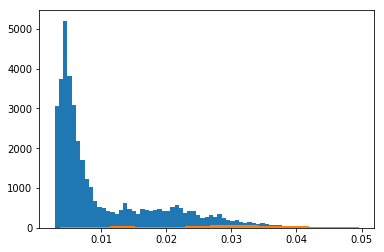

In [59]:
plt.hist(cv_pred[y_test_out==0,1], bins='auto')
plt.hist(cv_pred[y_test_out==1,1], bins='auto')

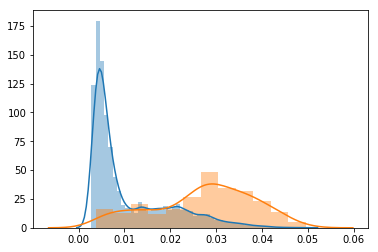

In [60]:
import seaborn as sns

sns.distplot(cv_pred[y_test_out==0,1])
sns.distplot(cv_pred[y_test_out==1,1]);


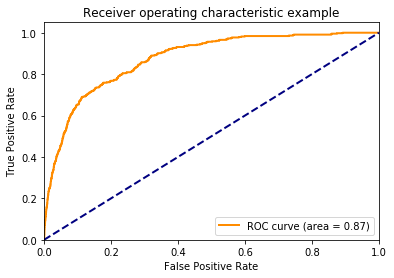

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_out, cv_pred[:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

#print roc_auc_score(y_test, cv_pred)
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Examine how the RMSE changes as the optimal cutoff changes

In [46]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [47]:
def calculate_cutoff(target, pred_targ, pred_prob):
    val_to_check = np.arange(0,max(pred_prob)+.001,0.0001)
    rmse_vals = np.zeros(len(val_to_check))
    new_score = np.zeros(len(target))

    for i in range(0,len(val_to_check)):
        new_score = np.array(list(pred_targ))
        new_score[pred_prob > val_to_check[i]] = min(target)
        rmse_vals[i] = (rmse(new_score,target))
    
    print(min(rmse_vals))
    return val_to_check[np.argmin(rmse_vals)]

In [48]:
x = calculate_cutoff(y_test_targ, oofT, cv_pred[:,1])

3.6280427102388817


In [49]:
np.arange(0,0.07,0.0001)[np.argmin(x)]

0.0

In [50]:
rmse(oofT,y_test_targ)

3.632645550180642

In [51]:
max(cv_pred[y_test_out==0,1])

0.04894905343244911

In [52]:
val_to_check = np.arange(0,1.01,0.01)
rmse_vals = np.zeros(len(val_to_check))
new_score = np.zeros(len(y_test_targ))

new_score = np.array(list(oofT))
new_score[cv_pred[:,1] > 0.05] = min(y_test_targ)
rmse_new = rmse(new_score,y_test_targ)

In [53]:
rmse_new

3.632645550180642

In [114]:
min(oofT)

-14.744207689371121

In [31]:
train_filtered.isnull().sum()

first_active_month                       0
card_id                                  0
feature_1                                0
feature_2                                0
feature_3                                0
elapsed_time                             0
hist_transactions_count              30959
hist_category_1_sum                  30959
hist_category_1_mean                 30959
hist_category_2_1.0_mean             30959
hist_category_2_2.0_mean             30959
hist_category_2_3.0_mean             30959
hist_category_2_4.0_mean             30959
hist_category_2_5.0_mean             30959
hist_category_3_A_mean               30959
hist_category_3_B_mean               30959
hist_category_3_C_mean               30959
hist_merchant_id_nunique             30959
hist_state_id_nunique                30959
hist_city_id_nunique                 30959
hist_purchase_amount_sum             30959
hist_purchase_amount_std             51988
hist_installments_sum                30959
hist_instal